In [4]:
import sys, time, os, asyncio
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy import signal
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, clipDataToEvent, calcNextDay
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [1]:
def get_freq_psd(vals, timestep):

    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)

    return (frequencies, psd)

def get_efd_data(begin, end, client):

    """Extract all the MTMount data from the EFD and add to dict.

    Args:
        begin (str): The start time of the query.
        end (str): The end time of the query.
        client (object): influx client

    Returns:
        dict: A dictionary containing the MTMount data.
    """

    query_dict = {}

    query_dict["el"] = getEfdData(
        client,
        "lsst.sal.MTMount.elevation",
        columns=["private_sndStamp", "private_efdStamp", "actualPosition", "actualVelocity", "actualTorque"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    query_dict["az"] = getEfdData(
        client,
        "lsst.sal.MTMount.azimuth",
        columns=["private_sndStamp", "private_efdStamp", "actualPosition", "actualVelocity", "actualTorque"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    return query_dict

def get_vms_data(filename, begin_time, end_time, key_dict):

    """Extract VMS data from a HDF5 file.

    Args:
        filename (str): The path to the HDF5 file.
        begin_time (float): The start time of the query (unix, utc).
        end_time (float): The end time of the query (unix, utc).

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the VMS data.
    """

    f = h5py.File(filename, 'r')
    times = f['timestamp'][::1]
    mkeys = [1, 2, 3]
    dkeys = 'XYZ'
    sel = (times > begin_time) & (times < end_time)
    data_dict = {}
    data_dict['times'] = times[sel]  
    for i, m in enumerate(mkeys):
        for j, d in enumerate(dkeys):
            key = f'{m} {d}'
            data_dict[key_dict[key]] = f[key][::1][sel]
    data_frame = pd.DataFrame(data_dict)
    return data_frame

def get_peak_points(freq, psd, height=0.01):
    """
    Get the peak points of the power spectral density (PSD).

    Args:
        freq (numpy.ndarray): The frequency vector.
        psd (numpy.ndarray): The power spectral density.
        height (float): The minimum peak height.

    Returns:
        numpy.ndarray: The peak points.
    """

    # Find the peak indices and heights.
    peak_ind, peak_dict = find_peaks(psd, height=height)
    peaks = freq[peak_ind]

    # If there are no peaks, return None.
    if len(peaks) < 1:
        return None

    # Find the sub-peaks within each group of peaks that are close in frequency.
    points = []
    for i, peak in enumerate(peaks):
        sel = (abs(peaks - peak) < 1)
        sub_peaks = peaks[sel]
        sub_heights = peak_dict['peak_heights'][sel]
        points.append(sub_peaks[np.argmax(sub_heights)])

    # Return the unique peak points.
    return np.unique(np.array(points))

def get_vms_data(filename, begin_time, end_time, key_dict):

    """Extract VMS data from a HDF5 file.

    Args:
        filename (str): The path to the HDF5 file.
        begin_time (float): The start time of the query (unix, utc).
        end_time (float): The end time of the query (unix, utc).

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the VMS data.
    """

    f = h5py.File(filename, 'r')
    times = f['timestamp'][::1]
    if "m1m3" in sorted(key_dict.values())[0]:
        mkeys = [1, 2, 3]
        dkeys = 'XYZ'
    if "m2" in sorted(key_dict.values())[0]:
        mkeys = [1, 2, 3, 4, 5, 6]
        dkeys = 'XYZ'
    sel = (times > begin_time) & (times < end_time)
    data_dict = {}
    data_dict['times'] = times[sel]  
    for i, m in enumerate(mkeys):
        for j, d in enumerate(dkeys):
            key = f'{m} {d}'
            data_dict[key_dict[key]] = f[key][::1][sel]
    data_frame = pd.DataFrame(data_dict)
    return data_frame

In [2]:
key_m1m3_dict={'1 X': 'm1m3_x_1', 
          '1 Y': 'm1m3_y_1', 
          '1 Z': 'm1m3_z_1', 
          '2 X': 'm1m3_x_2', 
          '2 Y': 'm1m3_z_2', 
          '2 Z': 'm1m3_y_2', 
          '3 X': 'm1m3_x_3', 
          '3 Y': 'm1m3_y_3', 
          '3 Z': 'm1m3_z_3'
}
vms_m1m3_filename="/home/p/pferguso/u/scratch/vms_data/M1M3-2023-06-28T0000.hdf"

key_m2_dict={'1 X': 'm2_x_1', 
          '1 Y': 'm2_y_1', 
          '1 Z': 'm2_z_1', 
          '2 X': 'm2_x_2', 
          '2 Y': 'm2_z_2', 
          '2 Z': 'm2_y_2', 
          '3 X': 'm2_x_3', 
          '3 Y': 'm2_z_3', 
          '3 Z': 'm2_y_3', 
          '4 X': 'm2_x_4', 
          '4 Y': 'm2_y_4', 
          '4 Z': 'm2_z_4', 
          '5 X': 'm2_x_5', 
          '5 Y': 'm2_z_5', 
          '5 Z': 'm2_y_5',
          '6 X': 'm2_x_6', 
          '6 Y': 'm2_z_6', 
          '6 Z': 'm2_y_6', 
}
vms_m2_filename="/home/p/pferguso/u/scratch/vms_data/M2-2023-06-28T00:00.hdf"

### setup tma events

For this test we wanted, force balance on, mirror raised, and no slew
for the time range '2023-06-28 00:13:30'- '2023-06-28 00:15:00'

- assuming "lsst.sal.MTM1M3.appliedBalanceForces" being nonzero means the force balance is on then: https://usdf-rsp.slac.stanford.edu/chronograf/sources/1/chronograf/data-explorer?query=SELECT%20%22fx%22%2C%20%22fy%22%2C%20%22fz%22%20FROM%20%22efd%22.%22autogen%22.%22lsst.sal.MTM1M3.appliedBalanceForces%22%20WHERE%20time%20%3E%20%3AdashboardTime%3A%20AND%20time%20%3C%20%3AupperDashboardTime%3A#
- mirror was raised at 06/27/2023 19:39:10 and not lowered according to "lsst.sal.MTM1M3.command_raiseM1M3"
- telescope was between slews
  

In [5]:
dayObs=20230628
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)
slews=[e for e in events if e.type==TMAState.SLEWING]

### query data

In [23]:
begin_time=Time('2023-06-28 00:13:30', format="iso", scale="utc")
end_time=Time('2023-06-28 00:15:00', format="iso", scale="utc")
efd_dict=get_efd_data(begin_time, end_time, eventMaker.client)
vms_m1m3_data=get_vms_data(vms_m1m3_filename, begin_time.unix, end_time.unix, key_dict=key_m1m3_dict)
vms_m2_data=get_vms_data(vms_m2_filename, begin_time.unix, end_time.unix, key_dict=key_m2_dict)

In [24]:
# compute quadratic sum of accelerations in each channel
for j in np.arange(3) +1:
    vms_m1m3_data[f"total_{j}"] = np.linalg.norm(vms_m1m3_data[[f"m1m3_{i}_{j}" for i in ["x","y","z"]]].values, axis=1)

for j in np.arange(6) + 1: 
    vms_m2_data[f"total_{j}"] = np.linalg.norm(vms_m2_data[[f"m2_{i}_{j}" for i in ["x","y","z"]]].values, axis=1)



### Plots
 - First plot is just plotting the vms data (and elevation telemetry)
 - second plot is spectrograms of the vms data
 - third plot a psd of all the vms data

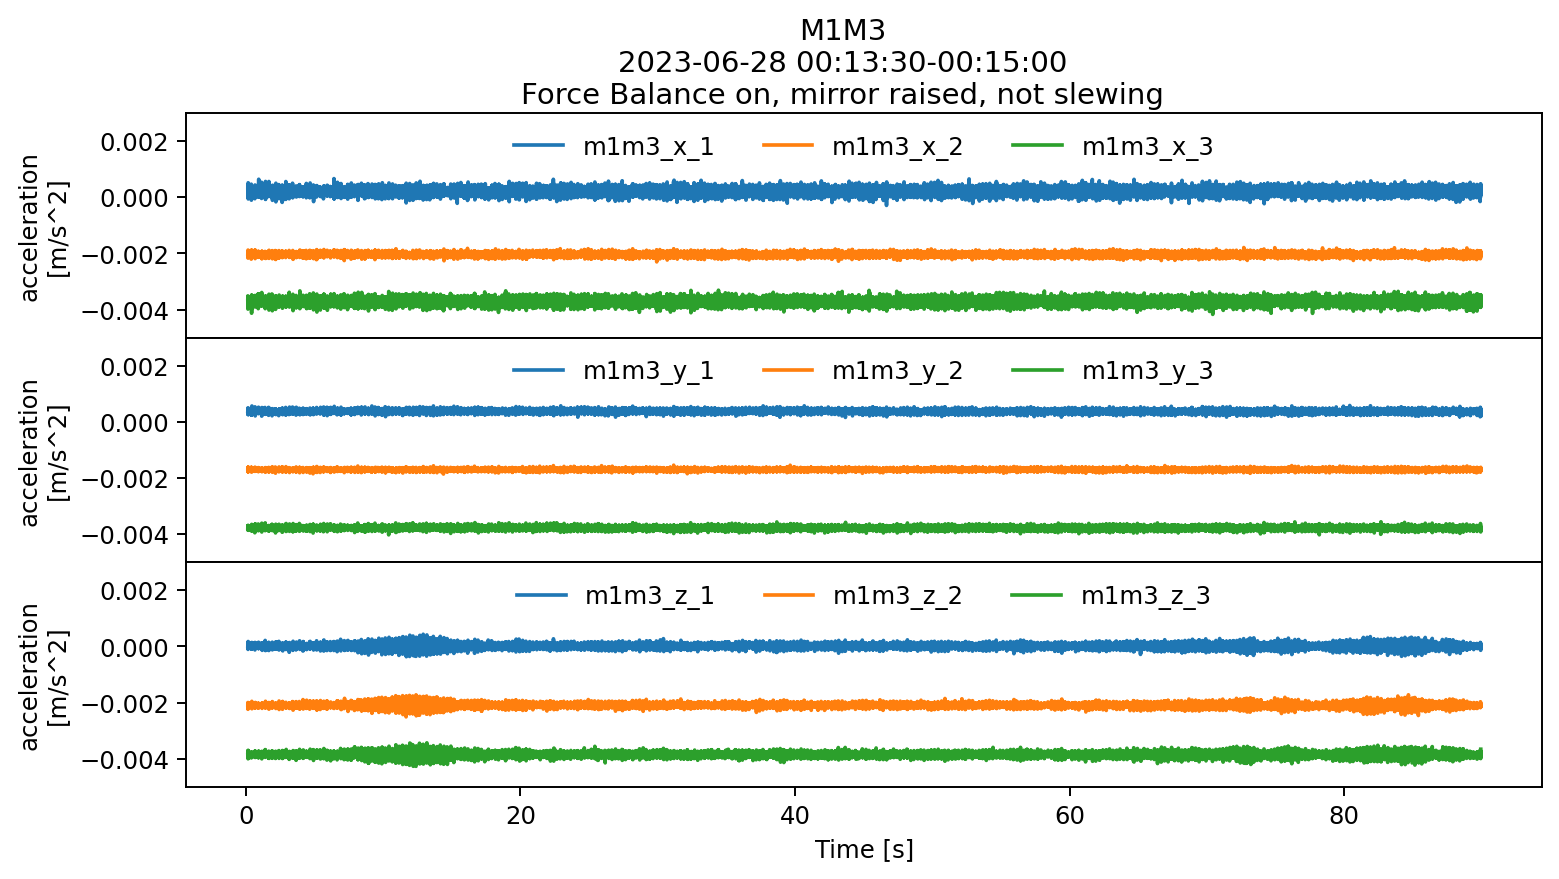

In [7]:
fig, axs=plt.subplots(3, dpi=175, sharex=True, figsize=(10,5))
plt.suptitle(f"M1M3\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\nForce Balance on, mirror raised, not slewing", y=0.99)
ax=axs[0]
for i in np.arange(3):

    axs[0].plot((Time(vms_m1m3_data["times"], format="unix")- begin_time).sec, 
               vms_m1m3_data[f"m1m3_x_{i+1}"]  - 0.002 * i,
               label=f"m1m3_x_{i+1}")
    axs[1].plot((Time(vms_m1m3_data["times"], format="unix")- begin_time).sec, 
               vms_m1m3_data[f"m1m3_y_{i+1}"] - 0.002 * i,
               label=f"m1m3_y_{i+1}")
    axs[2].plot((Time(vms_m1m3_data["times"], format="unix")- begin_time).sec, 
               vms_m1m3_data[f"m1m3_z_{i+1}"] - 0.002 * i,
               label=f"m1m3_z_{i+1}"

              )
for i in np.arange(3):
    axs[i].legend(ncol=3, edgecolor="white", loc=9)
    axs[i].set_ylabel("acceleration\n[m/s^2]")
    axs[i].set_ylim(-0.005,0.003)
axs[2].set_xlabel("Time [s]")
plt.subplots_adjust(hspace=0)
plt.savefig(f'./vms_look_m1m3_{begin_time.iso.replace(" ", ".").replace(":","-")[:-4]}.png', facecolor="white")

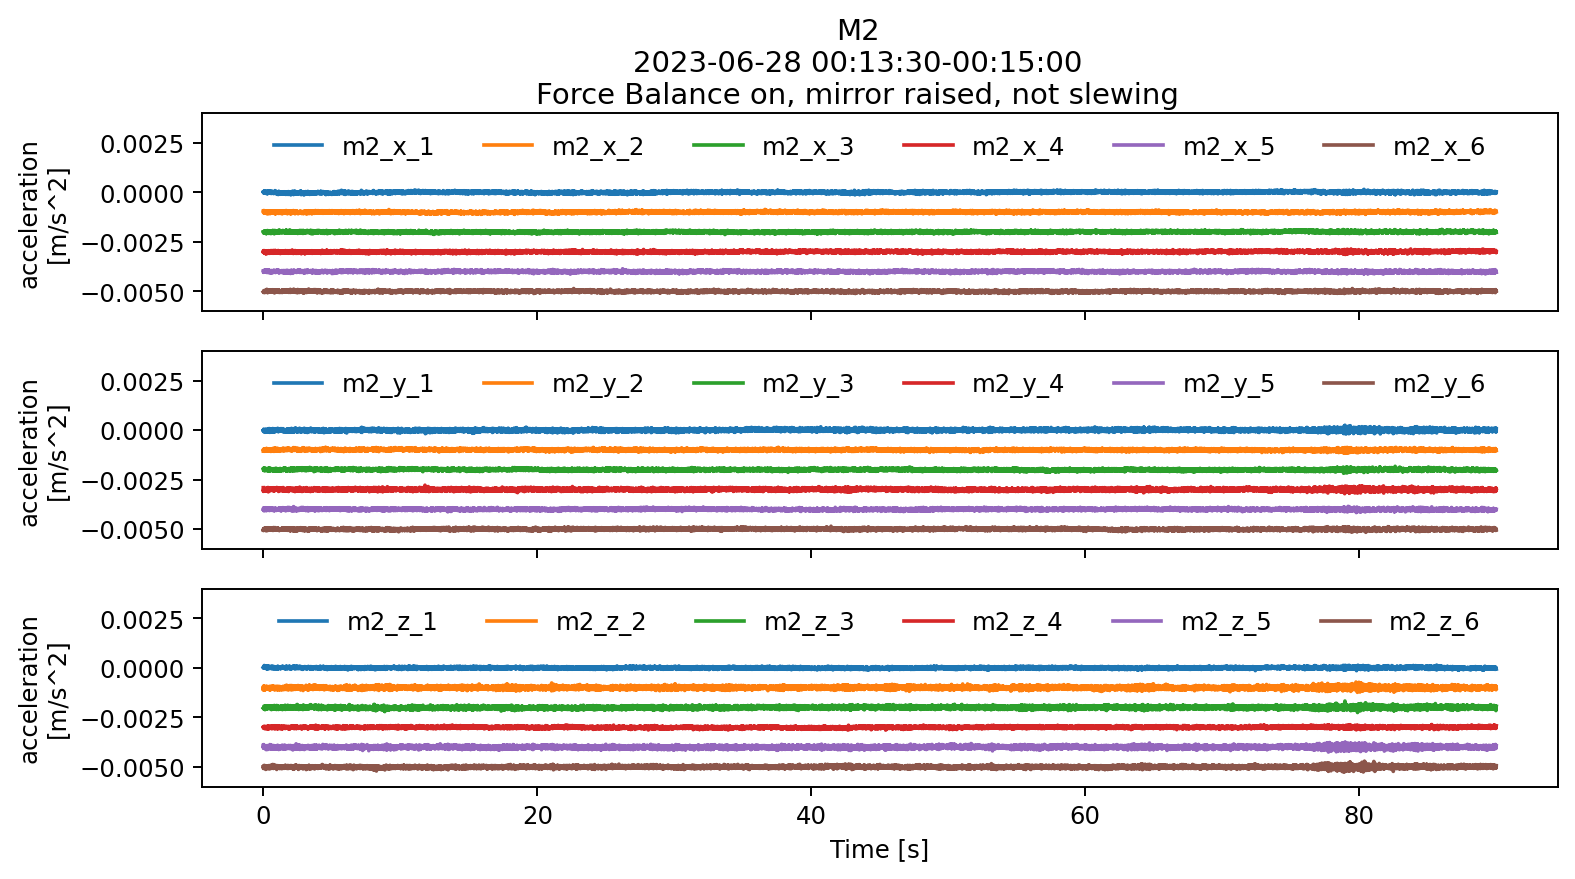

In [8]:
fig, axs=plt.subplots(3, dpi=175, sharex=True, figsize=(10,5))
plt.suptitle(f"M2\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\nForce Balance on, mirror raised, not slewing", y=0.99)
ax=axs[0]
for i in np.arange(6):

    axs[0].plot((Time(vms_m2_data["times"], format="unix")- begin_time).sec, 
               vms_m2_data[f"m2_x_{i+1}"]  - 0.001 * i - np.mean(vms_m2_data[f"m2_x_{i+1}"]),
               label=f"m2_x_{i+1}")
    axs[1].plot((Time(vms_m2_data["times"], format="unix")- begin_time).sec, 
               vms_m2_data[f"m2_y_{i+1}"] - 0.001 * i - np.mean(vms_m2_data[f"m2_y_{i+1}"]),
               label=f"m2_y_{i+1}")
    axs[2].plot((Time(vms_m2_data["times"], format="unix")- begin_time).sec, 
               vms_m2_data[f"m2_z_{i+1}"] - 0.001 * i - np.mean(vms_m2_data[f"m2_z_{i+1}"]),
               label=f"m2_z_{i+1}"

              )
for i in np.arange(3):
    axs[i].legend(ncol=6, edgecolor="white", loc=9)
    axs[i].set_ylabel("acceleration\n[m/s^2]")
    axs[i].set_ylim(-0.006,0.004)
axs[2].set_xlabel("Time [s]")
plt.savefig(f'./vms_look_m2_{begin_time.iso.replace(" ", ".").replace(":","-")[:-4]}.png', facecolor="white")

m1m3_x_1: 36, 70, 72, 78 Hz
m1m3_x_2: 36 Hz
m1m3_x_3: 80 Hz
m1m3_y_1: 20 Hz
m1m3_y_2 no peaks
m1m3_y_3 no peaks
m1m3_z_1: 5, 13, 20, 36 Hz
m1m3_z_2: 5, 13, 20 Hz
m1m3_z_3: 5, 13, 20 Hz


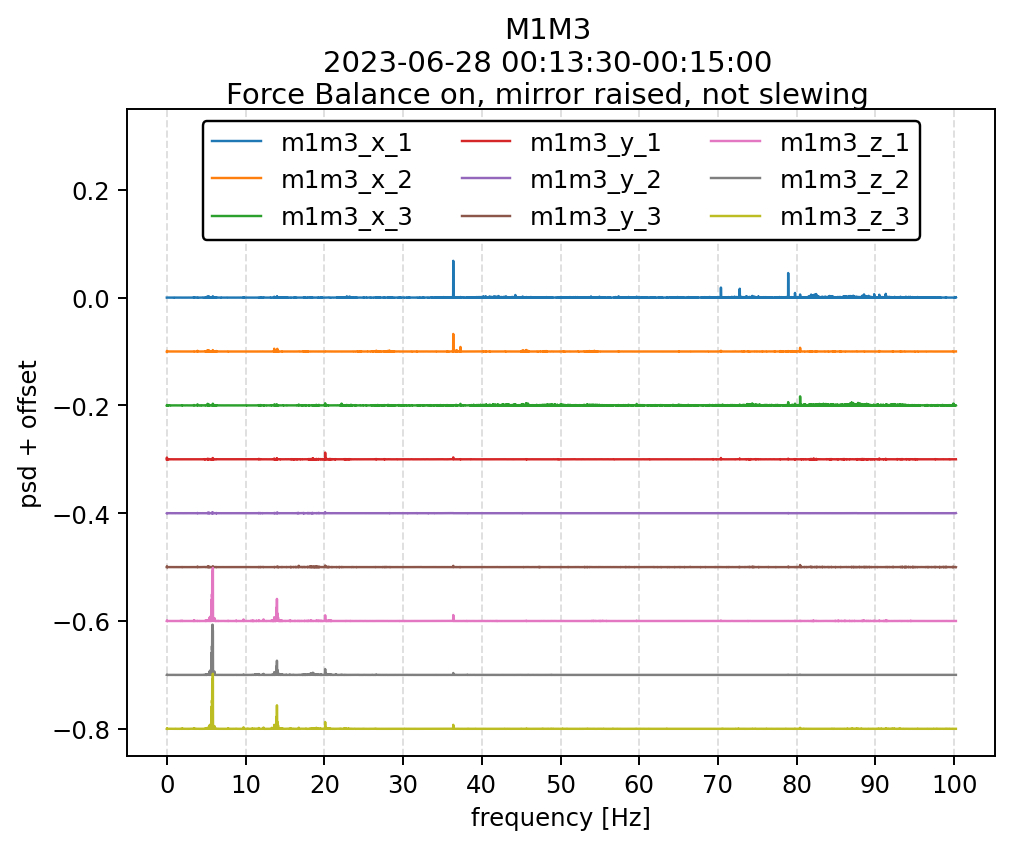

In [9]:
plt.figure(dpi=175)
plt.suptitle(f"M1M3\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\nForce Balance on, mirror raised, not slewing", y=0.99)
step=0.1
for i,key in enumerate([i for i in sorted(key_m1m3_dict.values()) if ("m1m3" in i)]):
    
    freq,psd=get_freq_psd(vms_m1m3_data[key], np.mean(np.diff(vms_m1m3_data["times"])))
    points_x=get_peak_points(freq, psd)
    if points_x is not None:
        points_y=np.ones_like(points_x) * i * step * -1
        print(f"{key}: {str([int(i) for i in points_x])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
    plt.plot(freq,psd - i * step, label=key, zorder=9, lw=1)

plt.legend(ncol=3, edgecolor="k", facecolor="white", loc=9, framealpha=1)
plt.ylim(-0.05 - i * step, 0.35)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
plt.xticks(np.arange(0,110,10))
plt.savefig("./psd_m1m3_vms.png", facecolor="white")

x
m2_x_1
m2_x_1: 0.0, 35.3 Hz
m2_x_2
m2_x_2: 0.0, 33.4 Hz
m2_x_3
m2_x_3: 0.0, 33.4 Hz
m2_x_4
m2_x_4: 0.0, 35.7 Hz
m2_x_5
m2_x_5: 0.1, 33.4 Hz
m2_x_6
m2_x_6: 0.0, 33.4 Hz
y
m2_y_1
m2_y_1: 0.0, 20.0, 68.8, 70.1 Hz
m2_y_2
m2_y_2: 0.0 Hz
m2_y_3
m2_y_3: 0.0, 33.4, 35.3 Hz
m2_y_4
m2_y_4: 0.2, 20.0, 68.5 Hz
m2_y_5
m2_y_5: 0.0, 35.3 Hz
m2_y_6
m2_y_6: 0.0, 35.7 Hz
z
m2_z_1
m2_z_1: 0.0, 33.4 Hz
m2_z_2
m2_z_2: 0.1, 20.0, 32.0, 33.3, 62.2, 68.5 Hz
m2_z_3
m2_z_3: 0.0, 29.6, 32.0, 33.3, 68.5, 68.9 Hz
m2_z_4
m2_z_4: 0.0, 33.4 Hz
m2_z_5
m2_z_5: 0.0, 20.0, 29.6, 32.0, 33.4, 62.2, 68.8 Hz
m2_z_6
m2_z_6: 0.0, 20.0, 29.6, 32.0, 33.3 Hz


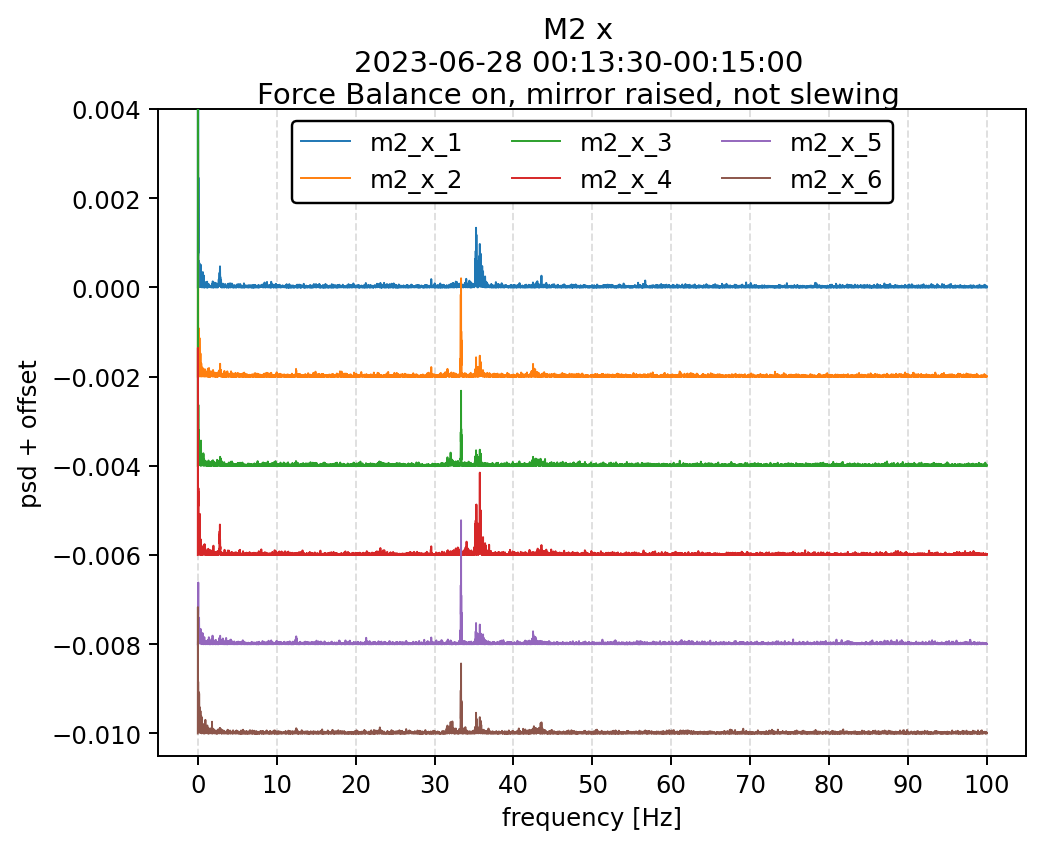

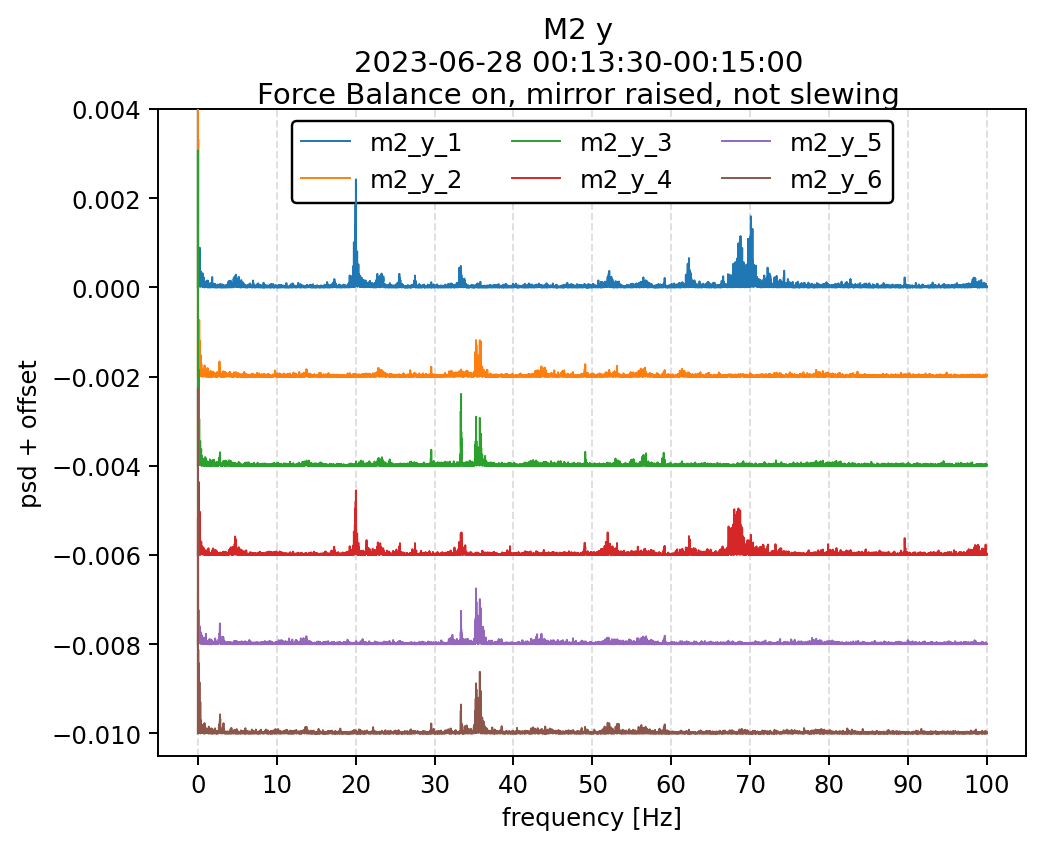

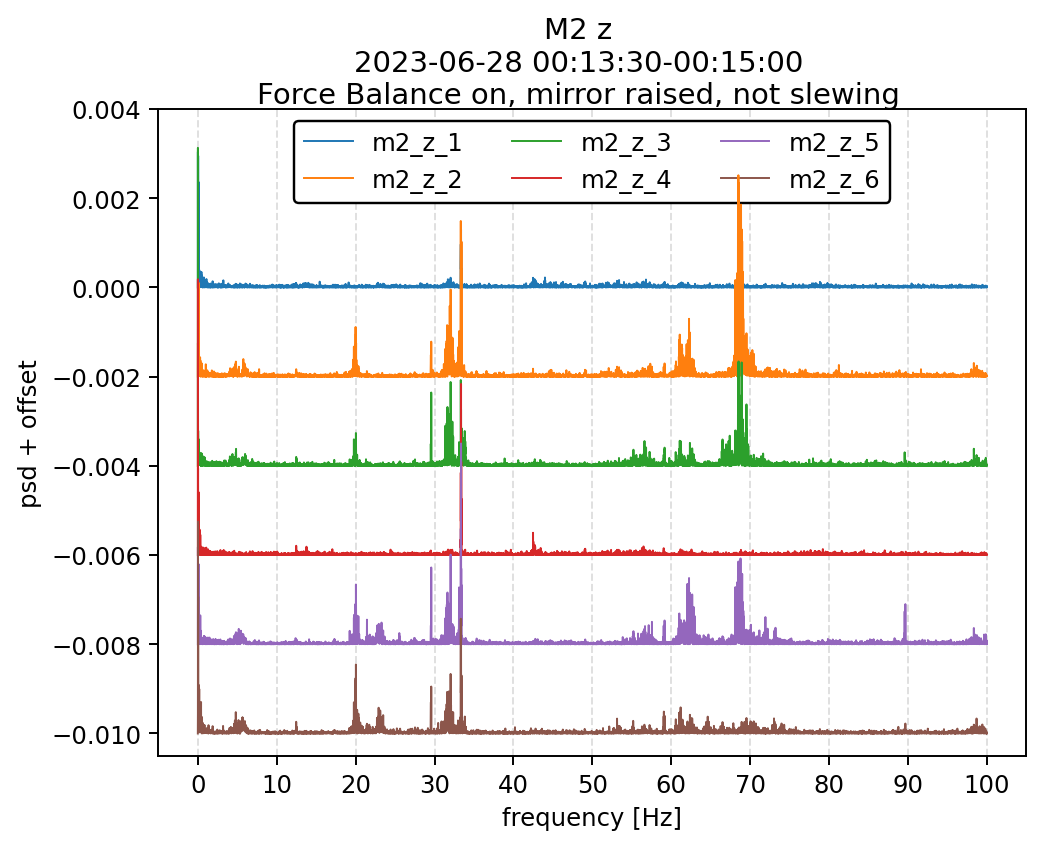

In [25]:


step=0.002
for base in ["x","y","z"]:
    plt.figure(dpi=175)
    print(base)
    plt.suptitle(f"M2 {base}\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\nForce Balance on, mirror raised, not slewing", y=0.99)
    for i,key in enumerate([i for i in sorted(key_m2_dict.values()) if (("m2" in i) and (base in i))]):
        print(key)
        freq,psd=get_freq_psd(vms_m2_data[key], np.mean(np.diff(vms_m2_data["times"])))
        points_x=get_peak_points(freq, psd, height=0.001)
        if points_x is not None:
            points_y=np.ones_like(points_x) * i * step * -1
            print(f"{key}: {str([np.round(i,1) for i in points_x])[1:-1]} Hz")
        else: 
            print(f"{key} no peaks")
        plt.plot(freq,psd - i * step, label=key, zorder=9, lw=0.8)
    plt.legend(ncol=3, edgecolor="k", facecolor="white", loc=9, framealpha=1)
    plt.ylim(-1 * step/4 - i * step, 2 * step)
    plt.xlabel("frequency [Hz]")
    plt.ylabel("psd + offset")
    plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
    plt.xticks(np.arange(0,110,10))
    plt.savefig(f"./psd_m2_{base}_vms.png", facecolor="white")
    #plt.close()

### Plot psd of sum of accelerations

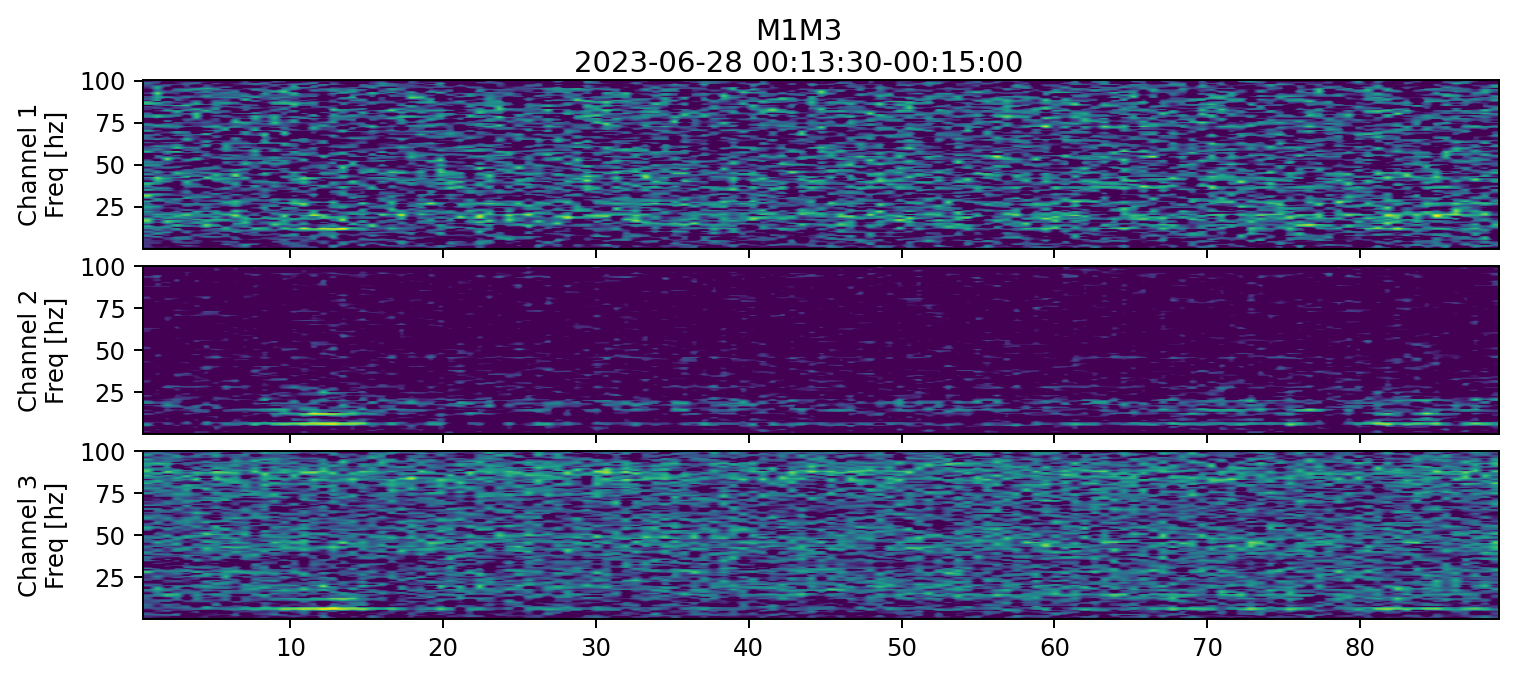

In [11]:
fs=1/np.mean(np.diff(vms_m1m3_data["times"]))
fig,axs=plt.subplots(3, dpi=175, figsize=(10,4), sharex=True)
plt.suptitle(f"M1M3\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}", y=0.97)


ax=axs[0]
ax.specgram(vms_m1m3_data["total_1"] - np.mean(vms_m1m3_data["total_1"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 1\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

ax=axs[1]
ax.specgram(vms_m1m3_data["total_2"] - np.mean(vms_m1m3_data["total_2"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 2\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

ax=axs[2]
ax.specgram(vms_m1m3_data["total_3"] - np.mean(vms_m1m3_data["total_3"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 3\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

plt.subplots_adjust(hspace=0.1)
plt.savefig("./spectrogram_total_accel_m1m3.png")

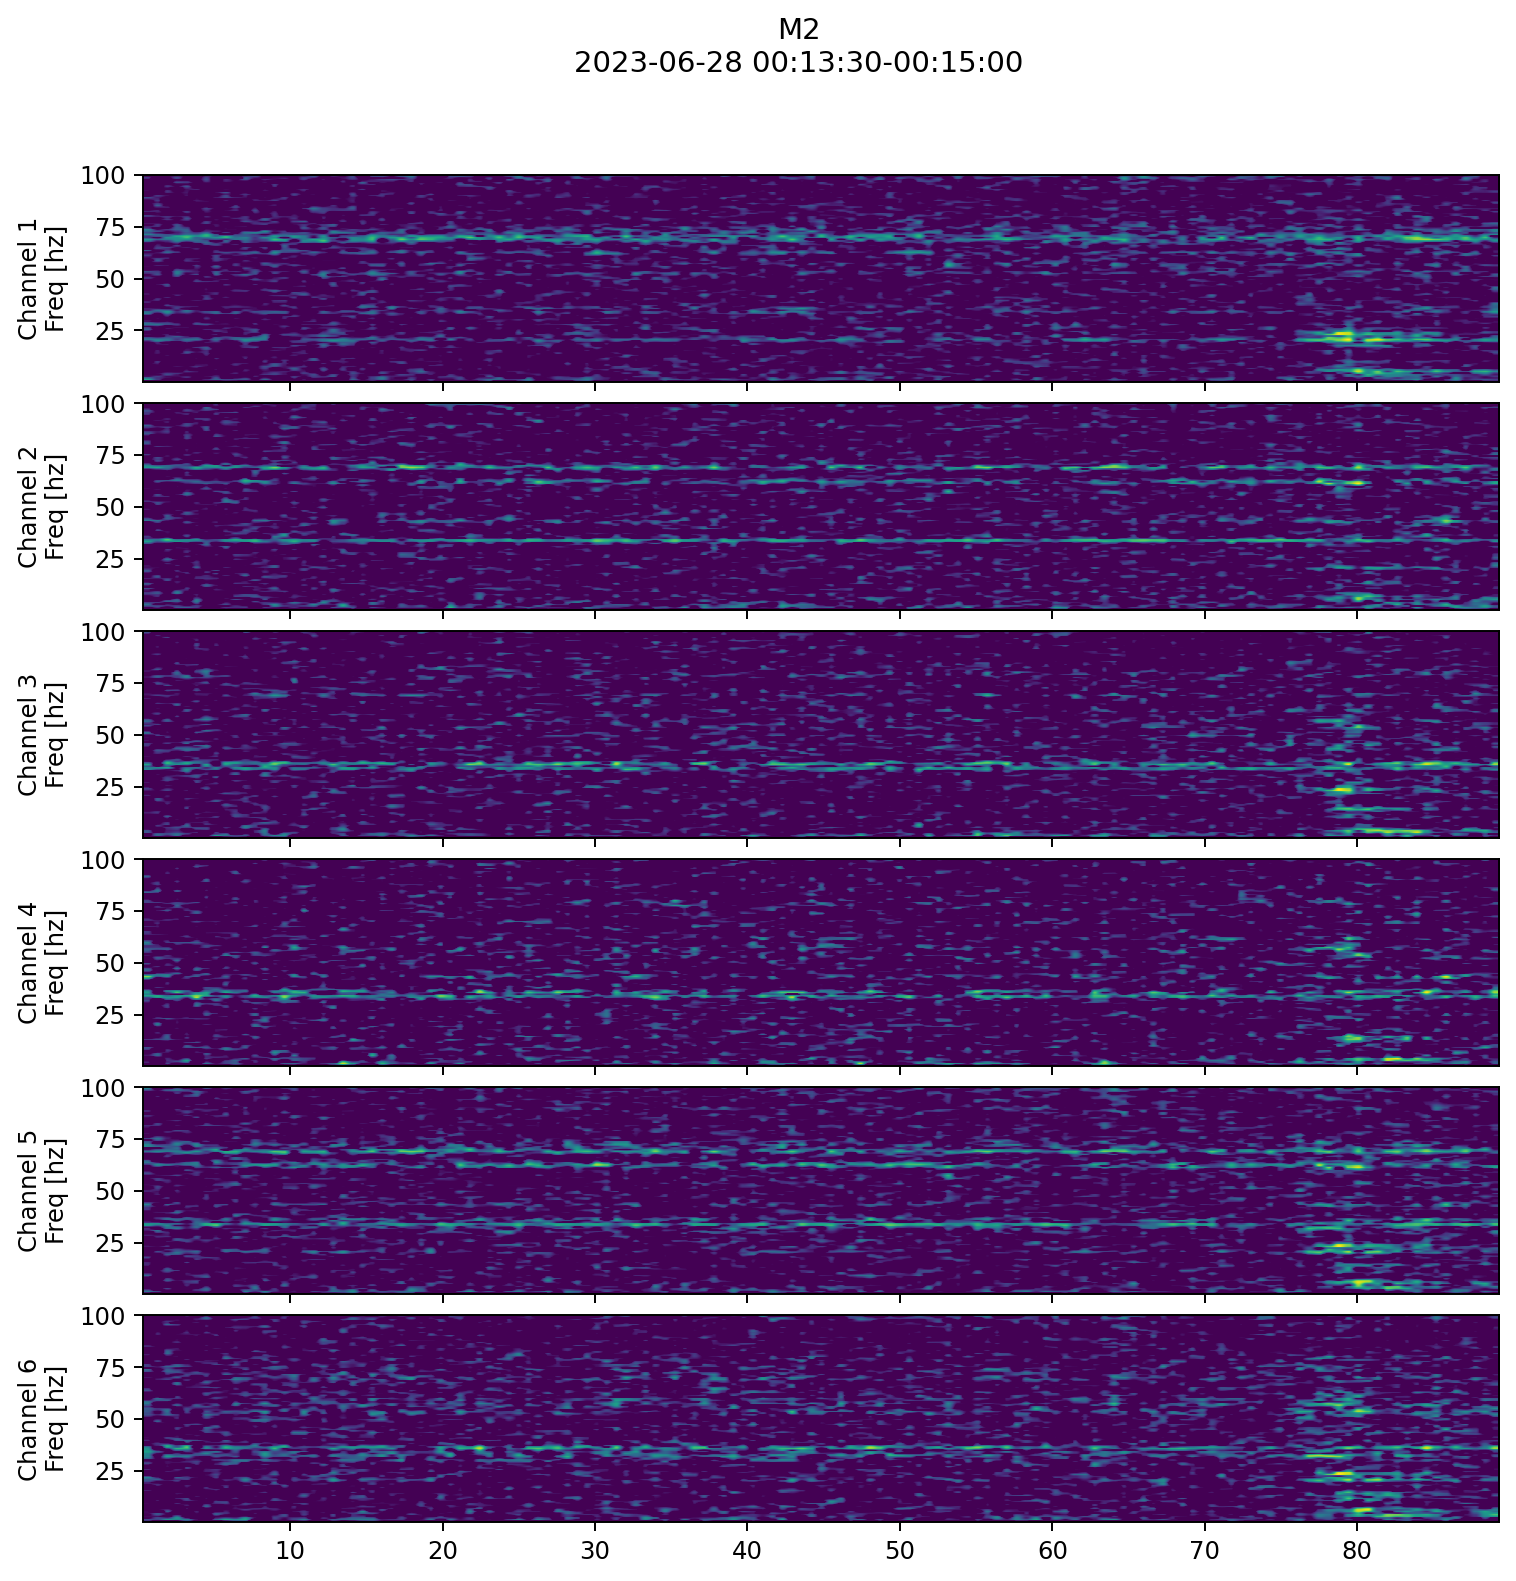

In [12]:
fs=1/np.mean(np.diff(vms_m2_data["times"]))
fig,axs=plt.subplots(6, dpi=175, figsize=(10,10), sharex=True)
plt.suptitle(f"M2\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}", y=0.97)


ax=axs[0]
ax.specgram(vms_m2_data["total_1"] - np.mean(vms_m2_data["total_1"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 1\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

ax=axs[1]
ax.specgram(vms_m2_data["total_2"] - np.mean(vms_m2_data["total_2"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 2\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

ax=axs[2]
ax.specgram(vms_m2_data["total_3"] - np.mean(vms_m2_data["total_3"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 3\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

ax=axs[3]
ax.specgram(vms_m2_data["total_4"] - np.mean(vms_m2_data["total_4"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 4\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

ax=axs[4]
ax.specgram(vms_m2_data["total_5"] - np.mean(vms_m2_data["total_5"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 5\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

ax=axs[5]
ax.specgram(vms_m2_data["total_6"] - np.mean(vms_m2_data["total_6"]), Fs=fs, detrend="mean", vmin=-110)
ax.set_ylabel("Channel 6\nFreq [hz]")
ax.set_yticks(np.arange(25,125,25))

plt.subplots_adjust(hspace=0.1)

total_1: 0.0, 20.1, 36.4, 78.9 Hz
total_2: 5.8 Hz
total_3: 0.0, 5.8, 14.0, 16.8, 19.0, 45.7, 80.4 Hz


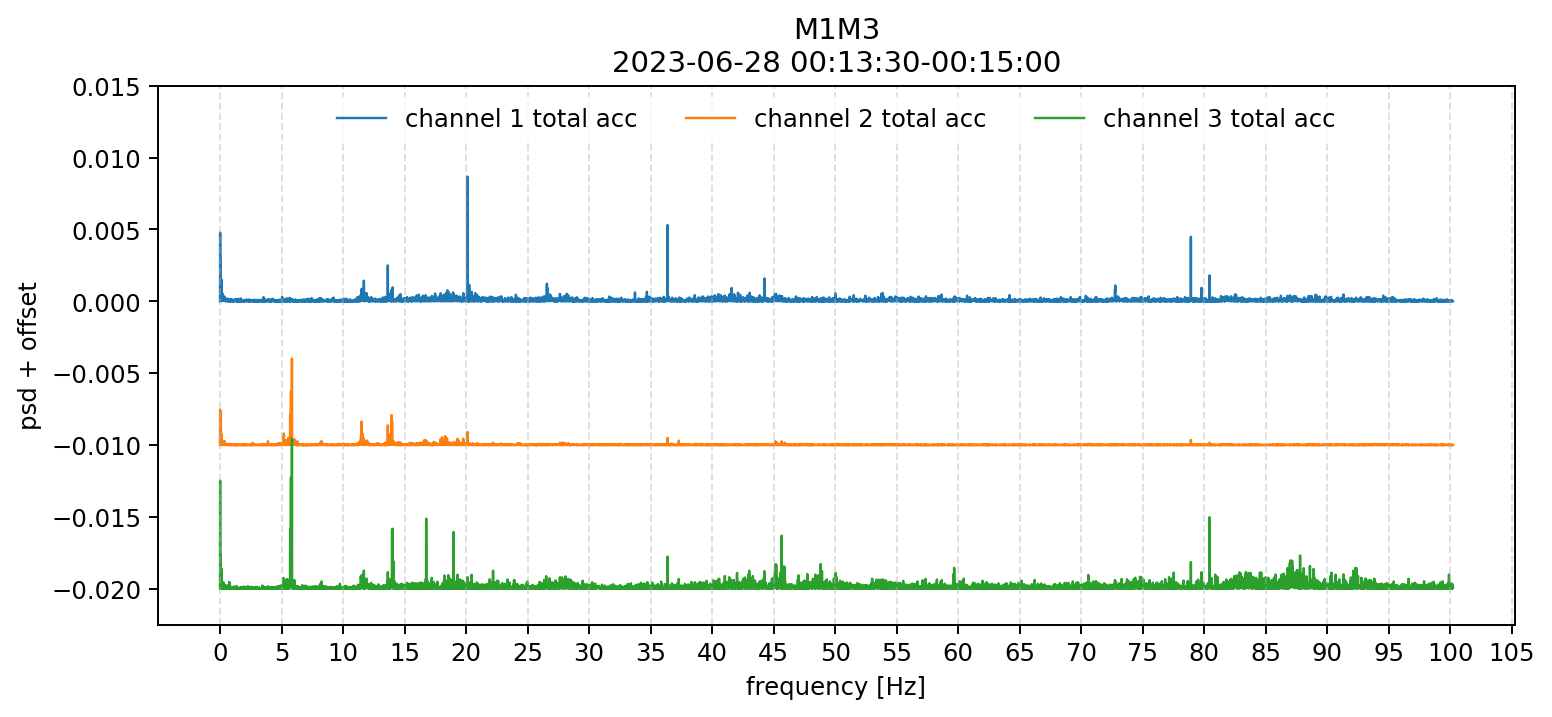

In [13]:
data_frame=vms_m1m3_data
step=0.01
cols=[i for i in data_frame.columns if "total" in i]
plt.figure(dpi=175, figsize=(10,4))
plt.title(f"M1M3\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
for i, key in enumerate(cols):
    freq,psd=get_freq_psd(data_frame[key], np.mean(np.diff(data_frame["times"])))
    points_x=get_peak_points(freq, psd, height=0.003)
    plt.plot(freq,psd - i * step, label=f"channel {i+1} total acc", zorder=1, lw=1)
    #plt.scatter(points_x, - 1  * np.ones_like(points_x) * i * step)
    if points_x is not None:
            points_y=np.ones_like(points_x) * i * step * -1
            print(f"{key}: {str([np.round(i,1) for i in points_x])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
plt.legend(ncol=3, loc=9, edgecolor="white")
plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
plt.xticks(np.arange(0,110,5))
plt.ylim(-1 * i * step - step/4, 1.5 * step)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.savefig("./total_psd_m1m3.png")

total_1: 20.0, 68.8, 70.1 Hz
total_2: 33.4, 61.1, 68.8 Hz
total_3: 33.4, 35.3 Hz
total_4: 33.4, 35.7 Hz
total_5: 33.4, 62.0, 68.5 Hz
total_6: 29.6, 31.8, 33.4, 35.7 Hz


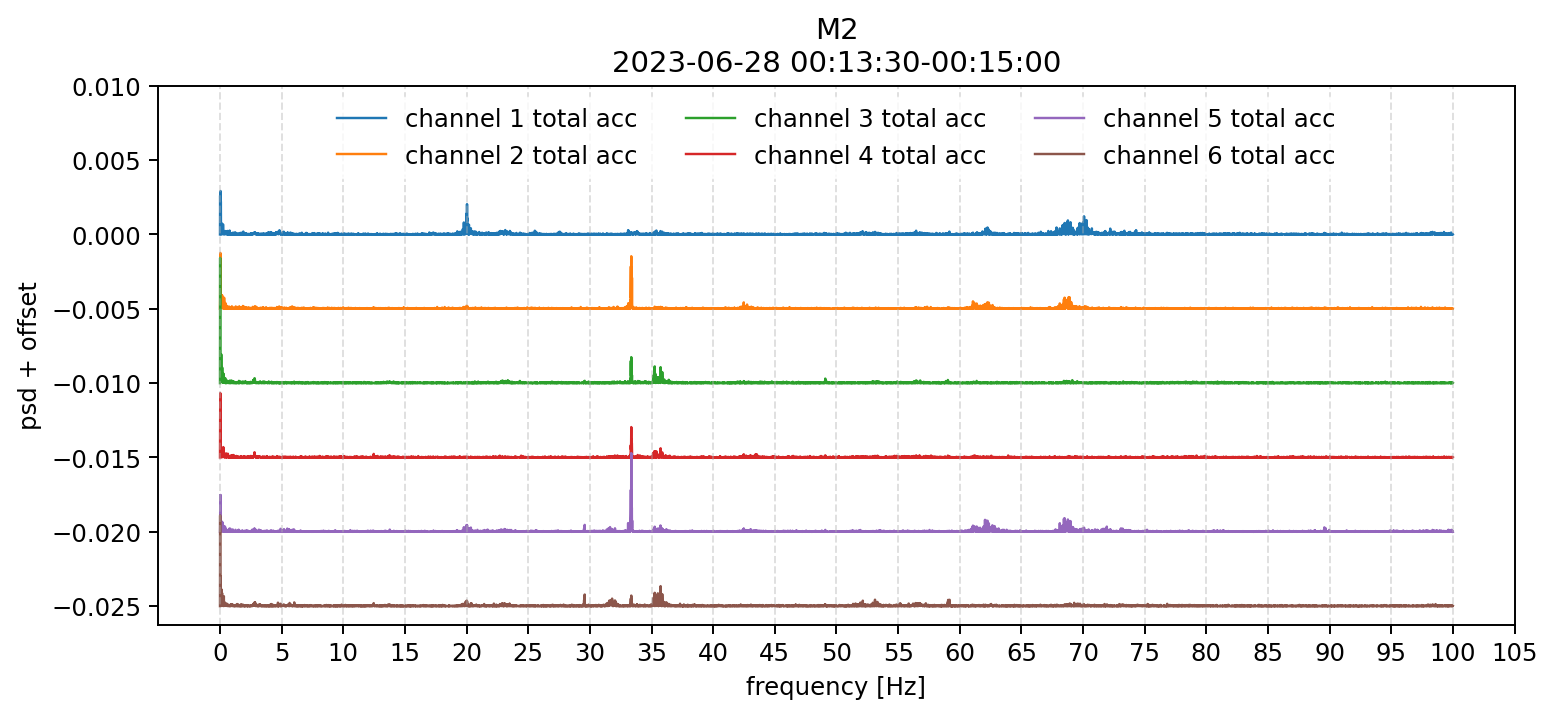

In [14]:
data_frame=vms_m2_data
step=0.005
cols=[i for i in data_frame.columns if "total" in i]
plt.figure(dpi=175, figsize=(10,4))
plt.title(f"M2\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
for i, key in enumerate(cols):
    freq,psd=get_freq_psd(data_frame[key], np.mean(np.diff(data_frame["times"])))
    points_x=get_peak_points(freq, psd, height=0.0005)
    plt.plot(freq,psd - i * step, label=f"channel {i+1} total acc", zorder=1, lw=1)
    #plt.scatter(points_x, - 1  * np.ones_like(points_x) * i * step)
    if points_x is not None:
            points_y=np.ones_like(points_x) * i * step * -1
            print(f"{key}: {str([np.round(i,1) for i in points_x if i > 0.1])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
plt.legend(ncol=3, loc=9, edgecolor="white")
plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
plt.xticks(np.arange(0,110,5))
plt.ylim(-1 * i * step - step/4, 2 * step)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.savefig("./total_psd_m2.png")

### log log for kevin
We dont seem to have enough signal to do everything unless I extend the time to include some slews

In [7]:
begin_time=Time('2023-06-28 00:13:30', format="iso", scale="utc")
end_time=Time('2023-06-28 01:07:00', format="iso", scale="utc")
efd_dict=get_efd_data(begin_time, end_time, eventMaker.client)
vms_m1m3_data=get_vms_data(vms_m1m3_filename, begin_time.unix, end_time.unix, key_dict=key_m1m3_dict)
vms_m2_data=get_vms_data(vms_m2_filename, begin_time.unix, end_time.unix, key_dict=key_m2_dict)
# compute quadratic sum of accelerations in each channel
for j in np.arange(3) +1:
    vms_m1m3_data[f"total_{j}"] = np.linalg.norm(vms_m1m3_data[[f"m1m3_{i}_{j}" for i in ["x","y","z"]]].values, axis=1)

for j in np.arange(6) + 1: 
    vms_m2_data[f"total_{j}"] = np.linalg.norm(vms_m2_data[[f"m2_{i}_{j}" for i in ["x","y","z"]]].values, axis=1)



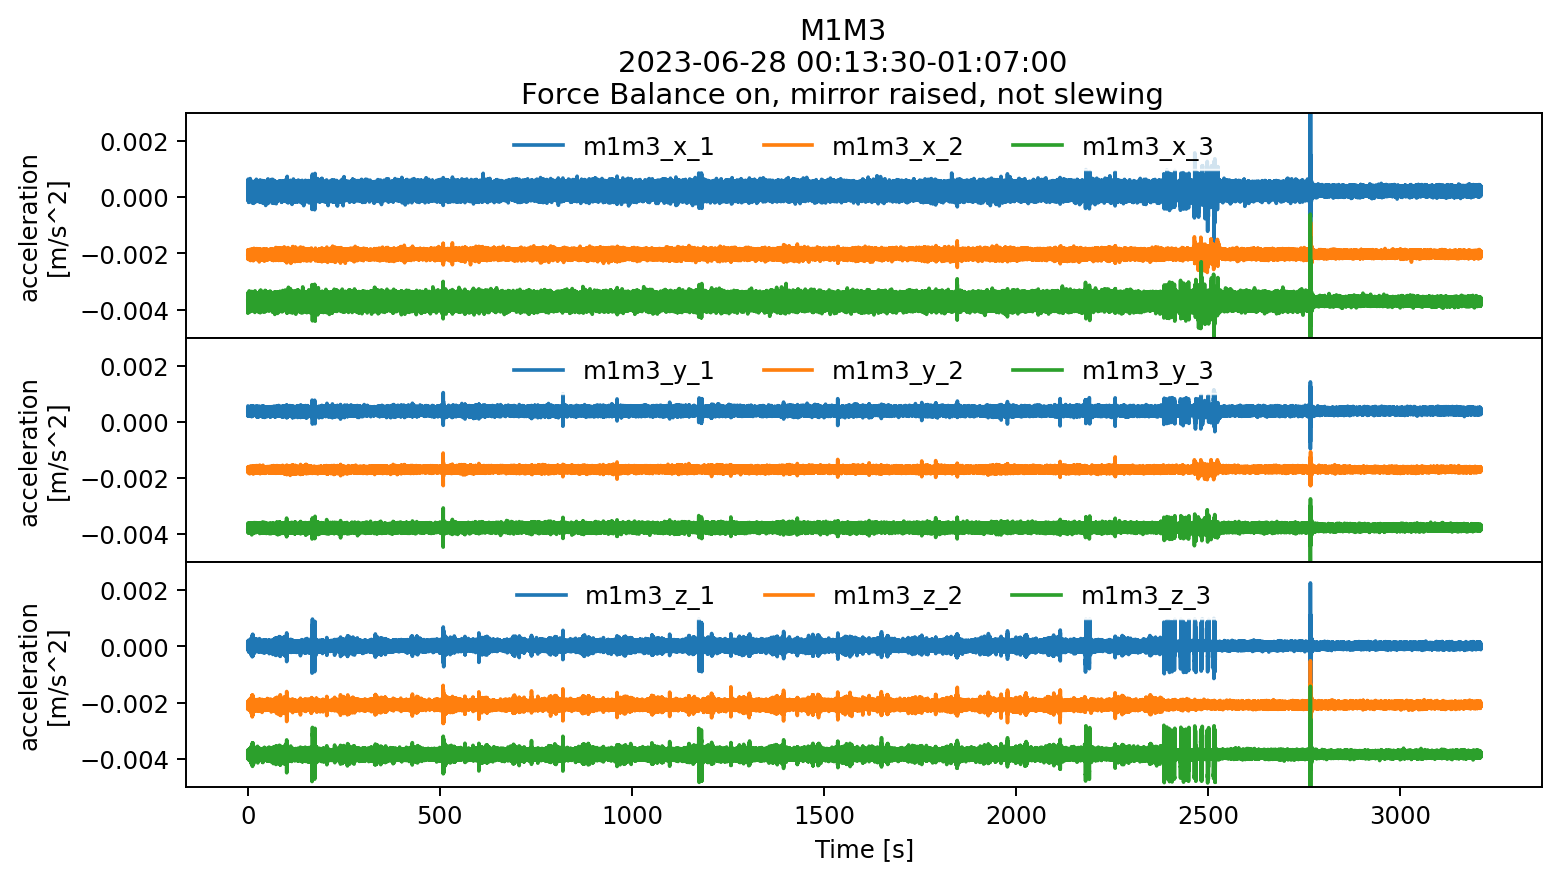

In [8]:
fig, axs=plt.subplots(3, dpi=175, sharex=True, figsize=(10,5))
plt.suptitle(f"M1M3\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\nForce Balance on, mirror raised, not slewing", y=0.99)
ax=axs[0]
for i in np.arange(3):

    axs[0].plot((Time(vms_m1m3_data["times"], format="unix")- begin_time).sec, 
               vms_m1m3_data[f"m1m3_x_{i+1}"]  - 0.002 * i,
               label=f"m1m3_x_{i+1}")
    axs[1].plot((Time(vms_m1m3_data["times"], format="unix")- begin_time).sec, 
               vms_m1m3_data[f"m1m3_y_{i+1}"] - 0.002 * i,
               label=f"m1m3_y_{i+1}")
    axs[2].plot((Time(vms_m1m3_data["times"], format="unix")- begin_time).sec, 
               vms_m1m3_data[f"m1m3_z_{i+1}"] - 0.002 * i,
               label=f"m1m3_z_{i+1}"

              )
for i in np.arange(3):
    axs[i].legend(ncol=3, edgecolor="white", loc=9)
    axs[i].set_ylabel("acceleration\n[m/s^2]")
    axs[i].set_ylim(-0.005,0.003)
axs[2].set_xlabel("Time [s]")
plt.subplots_adjust(hspace=0)
plt.savefig(f'./vms_look_m1m3_{end_time.iso.replace(" ", ".").replace(":","-")[:-4]}.png', facecolor="white")

In [12]:
vms_m1m3_data[f"m1m3_x_1"].max()-vms_m1m3_data[f"m1m3_x_1"].min()

0.007137298583984375

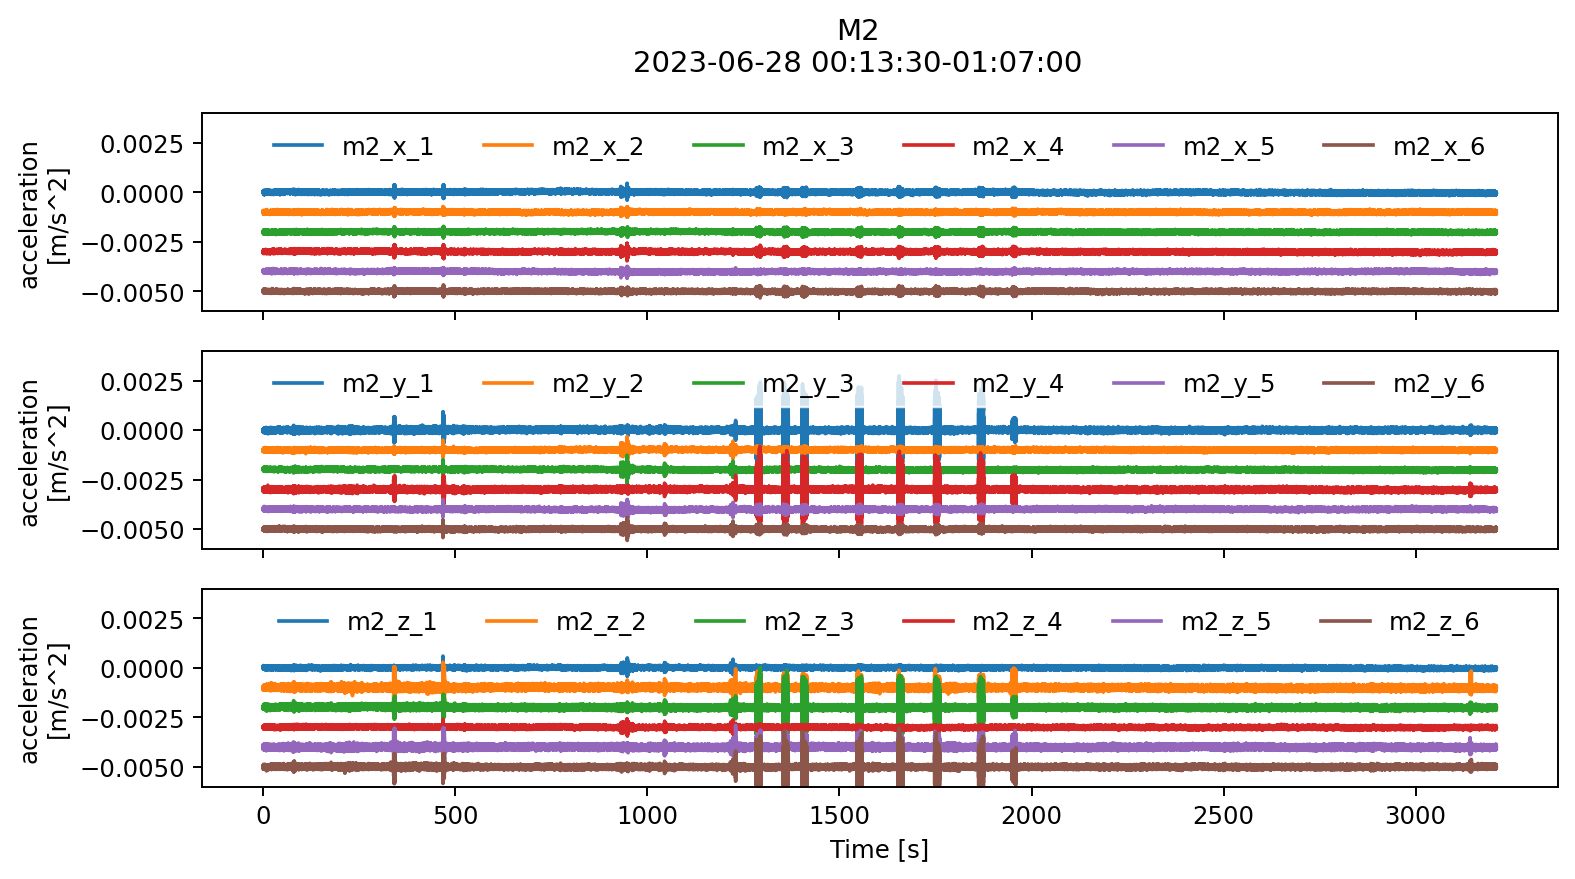

In [17]:
fig, axs=plt.subplots(3, dpi=175, sharex=True, figsize=(10,5))
plt.suptitle(f"M2\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}", y=0.99)
ax=axs[0]
for i in np.arange(6):

    axs[0].plot((Time(vms_m2_data["times"], format="unix")- begin_time).sec, 
               vms_m2_data[f"m2_x_{i+1}"]  - 0.001 * i - np.mean(vms_m2_data[f"m2_x_{i+1}"]),
               label=f"m2_x_{i+1}")
    axs[1].plot((Time(vms_m2_data["times"], format="unix")- begin_time).sec, 
               vms_m2_data[f"m2_y_{i+1}"] - 0.001 * i - np.mean(vms_m2_data[f"m2_y_{i+1}"]),
               label=f"m2_y_{i+1}")
    axs[2].plot((Time(vms_m2_data["times"], format="unix")- begin_time).sec, 
               vms_m2_data[f"m2_z_{i+1}"] - 0.001 * i - np.mean(vms_m2_data[f"m2_z_{i+1}"]),
               label=f"m2_z_{i+1}"

              )
for i in np.arange(3):
    axs[i].legend(ncol=6, edgecolor="white", loc=9)
    axs[i].set_ylabel("acceleration\n[m/s^2]")
    axs[i].set_ylim(-0.006,0.004)
axs[2].set_xlabel("Time [s]")
plt.savefig(f'./vms_look_m2_{end_time.iso.replace(" ", ".").replace(":","-")[:-4]}.png', facecolor="white")

total_1: 1.0, 11.7, 14.0, 20.1, 36.3, 40.1, 78.8, 80.3, 89.6 Hz
total_2: 5.8, 20.1 Hz
total_3: 1.0, 5.8, 11.7, 14.1, 20.1, 30.1, 40.4, 45.5, 59.6, 79.6, 80.3, 99.7 Hz


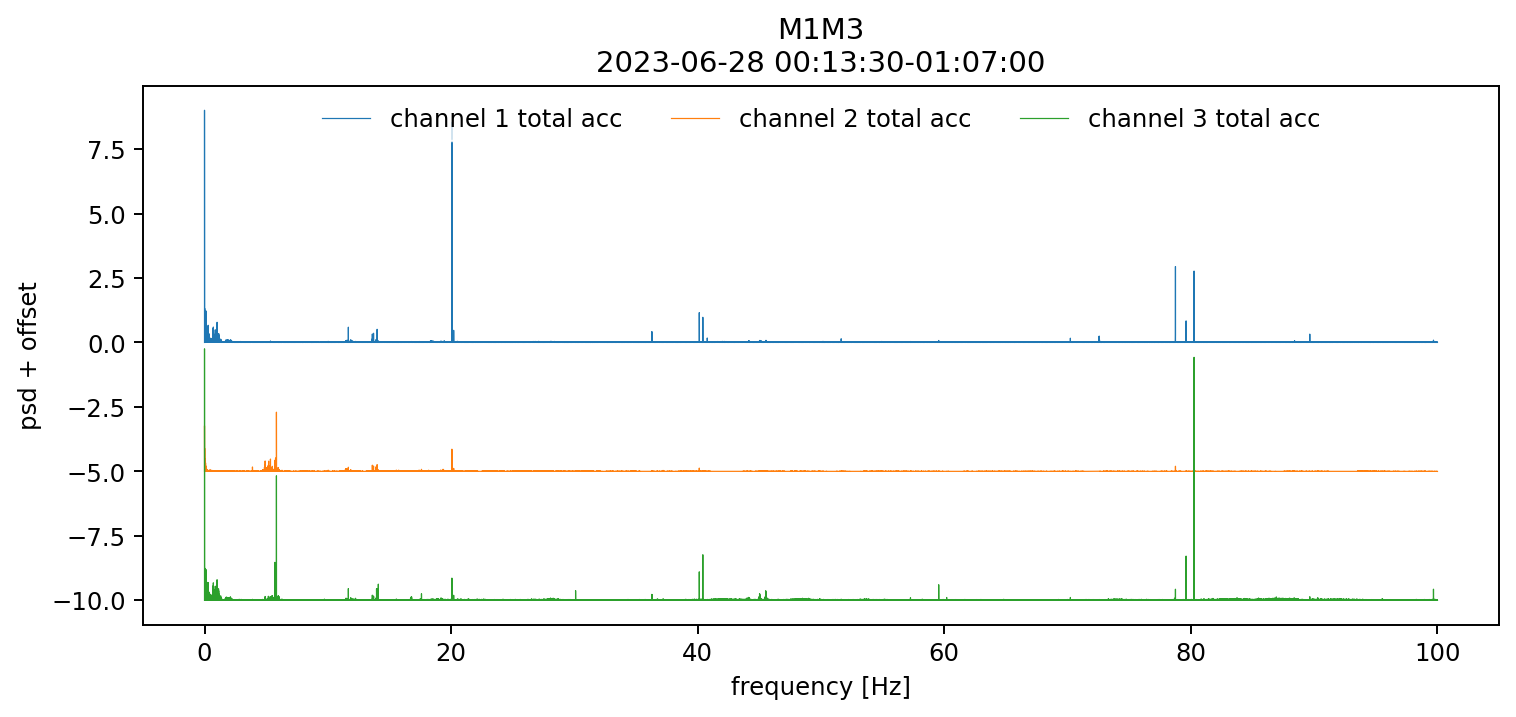

In [21]:
data_frame=vms_m1m3_data
step=5
cols=[i for i in data_frame.columns if "total" in i]
plt.figure(dpi=175, figsize=(10,4))
plt.title(f"M1M3\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
for i, key in enumerate(cols):
    freq,psd=get_freq_psd(data_frame[key], np.mean(np.diff(data_frame["times"])))
    points_x=get_peak_points(freq, psd, height=0.3)
    ydat=pd.DataFrame({"psd":psd})["psd"].rolling(1).mean()
    plt.plot(freq,ydat - i * step, label=f"channel {i+1} total acc", zorder=1, lw=0.5)
    #plt.scatter(points_x,   np.ones_like(points_x))
    if points_x is not None:
            points_y=np.ones_like(points_x) * i * step * -1
            print(f"{key}: {str([np.round(i,1) for i in points_x if i >= 1])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
plt.legend(ncol=3, loc=9, edgecolor="white")
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.savefig("total_psd_m1m3_long.png")

total_1: 1.2, 23.4, 24.6, 47.4, 48.6, 49.9, 71.4, 72.7, 96.0, 97.2 Hz
total_2: 33.3, 47.4, 48.6 Hz
total_3: 1.2 Hz
total_4: 1.2, 48.6, 96.0, 97.2 Hz
total_5: 33.4, 47.4, 48.6 Hz
total_6: 1.2, 47.4, 48.6 Hz


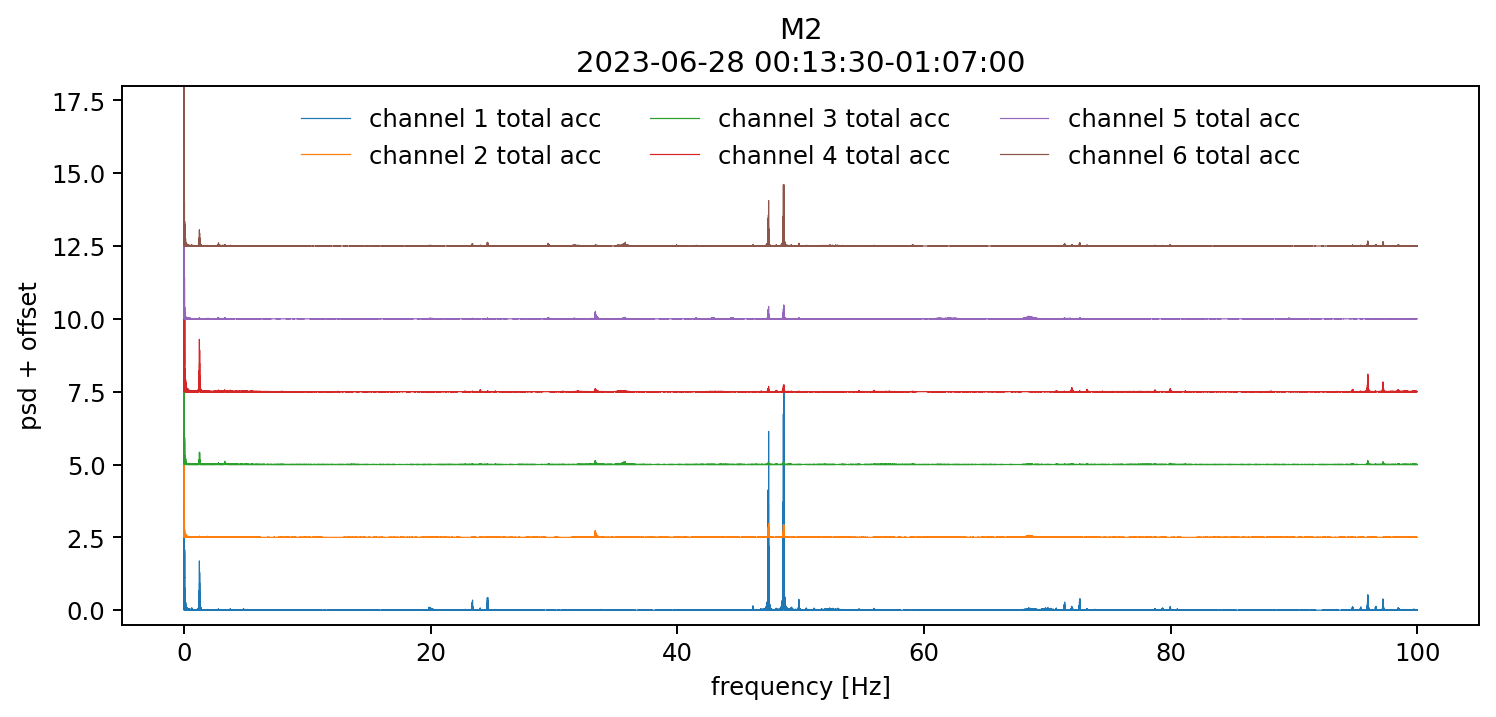

In [22]:
data_frame=vms_m2_data
step=2.5
cols=[i for i in data_frame.columns if "total" in i]
plt.figure(dpi=175, figsize=(10,4))
plt.title(f"M2\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
for i, key in enumerate(cols):
    freq,psd=get_freq_psd(data_frame[key], np.mean(np.diff(data_frame["times"])))
    points_x=get_peak_points(freq, psd, height=0.2)
    ydat=pd.DataFrame({"psd":psd})["psd"].rolling(1).mean()
    plt.plot(freq,ydat + i * step, label=f"channel {i+1} total acc", zorder=1, lw=0.5)
    #plt.scatter(points_x,   np.ones_like(points_x))
    if points_x is not None:
            points_y=np.ones_like(points_x) * i * step * -1
            print(f"{key}: {str([np.round(i,1) for i in points_x if i > 0.1])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
plt.legend(ncol=3, loc=9, edgecolor="white")
plt.ylim(-0.5,18)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.savefig("total_psd_m2_long.png", facecolor="white")


total_1: 0.0, 1.2, 23.4, 24.6, 47.4, 48.6, 49.9, 72.7, 96.0, 97.2 Hz
total_2: 0.0, 47.4, 48.6 Hz
total_3: 0.0, 1.2 Hz
total_4: 0.0, 1.2, 96.0, 97.2 Hz
total_5: 0.0, 47.4, 48.6 Hz
total_6: 0.0, 1.2, 47.4, 48.6 Hz


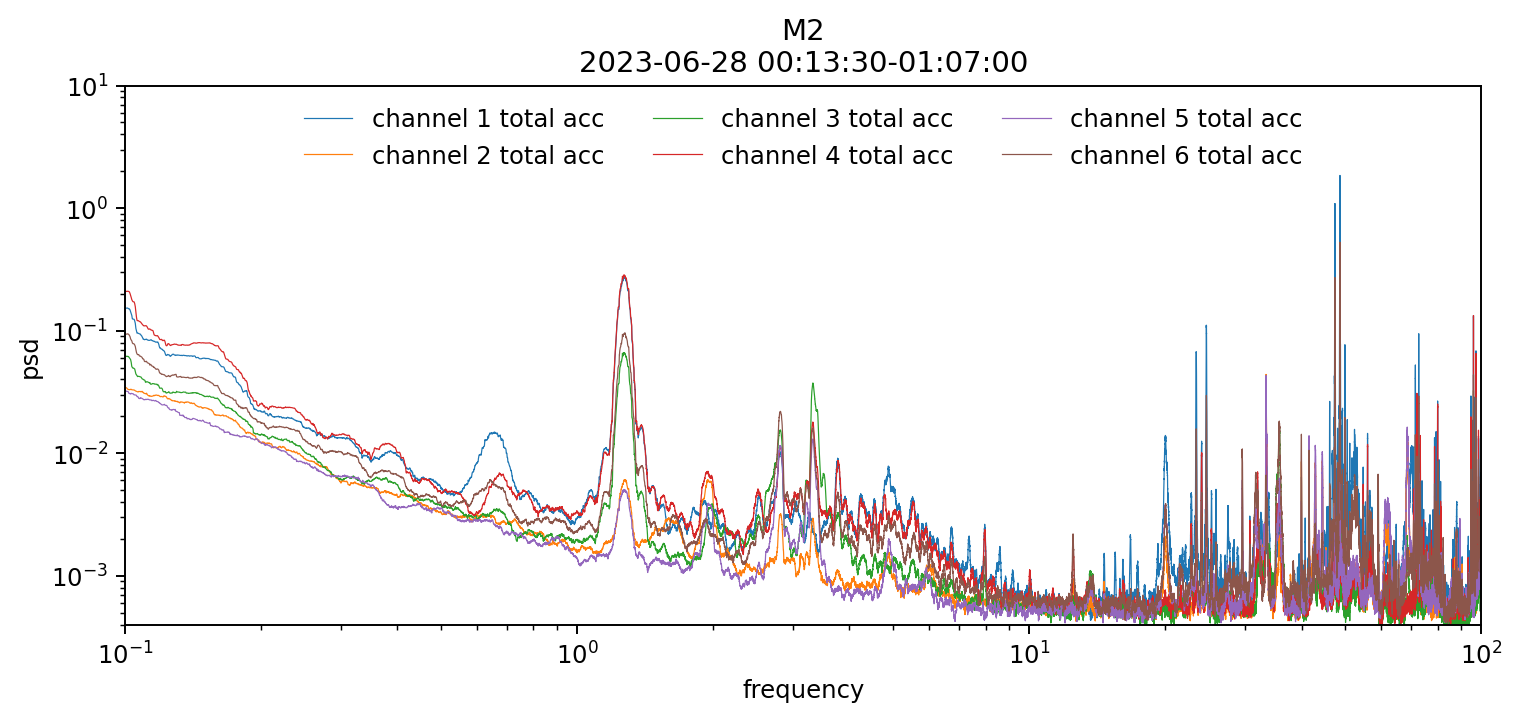

In [20]:
data_frame=vms_m2_data
step=0.000
cols=[i for i in data_frame.columns if "total" in i]
plt.figure(dpi=175, figsize=(10,4))
plt.title(f"M2\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}")
for i, key in enumerate(cols):
    freq,psd=get_freq_psd(data_frame[key], np.mean(np.diff(data_frame["times"])))
    points_x=get_peak_points(freq, psd, height=0.3)
    ydat=pd.DataFrame({"psd":psd})["psd"].rolling(200).mean()
    plt.plot(freq,ydat, label=f"channel {i+1} total acc", zorder=1, lw=0.5)
    #plt.scatter(points_x,   np.ones_like(points_x))
    if points_x is not None:
            points_y=np.ones_like(points_x) * i * step * -1
            print(f"{key}: {str([np.round(i,1) for i in points_x])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
plt.legend(ncol=3, loc=9, edgecolor="white")
#plt.ylim(-1 * i * step - 0.001, 0.005)
plt.yscale('log')
plt.xscale('log')
plt.ylim(4e-4,1e1)
plt.xlim(1e-1,1e2)
plt.xlabel("frequency")
plt.ylabel("psd")
plt.savefig("./total_psd_log_m2.png")

In [ ]:
filen